In [29]:
import pandas as pd
import numpy as np
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
raw_path = Path("C:/Users/archa/Desktop/Databricks/Data/raw/NTA_MTC_Claims_Synthetic_Data.xlsx")
processed_path = Path("C:/Users/archa/Desktop/Databricks/Data/processed")
staging_path = processed_path / "staging"
failed_path = processed_path / "qc_failed"

In [20]:
# Create folders if they don't exist
staging_path.mkdir(parents=True, exist_ok=True)
failed_path.mkdir(parents=True, exist_ok=True)

In [37]:
# Show first 5 rows
display(bronze_df.head())

,DATE,AMOUNT,COMPANY,ACCIDENT_STATE
0,2023-01-01,489,Blue Cross,NY
1,2023-01-02,544,Kaiser,TX
2,2023-01-03,404,Blue Cross,TX
3,2023-01-04,615,Kaiser,NY
4,2023-01-05,580,United,CA


In [38]:
bronze_df.describe(include='all').T


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
DATE,100,NaN,NaN,NaN,2023-02-19 12:00:00,2023-01-01 00:00:00,2023-01-25 18:00:00,2023-02-19 12:00:00,2023-03-16 06:00:00,2023-04-10 00:00:00,NaN
AMOUNT,100.0,NaN,NaN,NaN,575.56,103.0,348.0,597.0,809.75,995.0,264.243472
COMPANY,100,4,Aetna,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACCIDENT_STATE,100,4,NY,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# 🔹 Load and Clean Bronze Data
# -------------------------
all_sheets = pd.read_excel(raw_path, sheet_name=None, engine="openpyxl")
bronze_df = pd.concat(all_sheets.values(), ignore_index=True)

# Standardize column names
bronze_df.columns = bronze_df.columns.str.strip().str.replace(" ", "_").str.upper()

# Basic type conversion
date_columns = ['DATE_OF_LOSS', 'NOTICE_DATE', 'DATE']
for col in date_columns:
    bronze_df[col] = pd.to_datetime(bronze_df[col], errors='coerce')

bronze_df['AMOUNT'] = pd.to_numeric(bronze_df['AMOUNT'], errors='coerce')


In [30]:


bronze_df = pd.DataFrame({
    'DATE': pd.date_range(start='2023-01-01', periods=100, freq='D'),
    'AMOUNT': np.random.randint(100, 1000, 100),
    'COMPANY': np.random.choice(['Aetna', 'Kaiser', 'Blue Cross', 'United'], 100),
    'ACCIDENT_STATE': np.random.choice(['CA', 'TX', 'NY', 'FL'], 100)
})


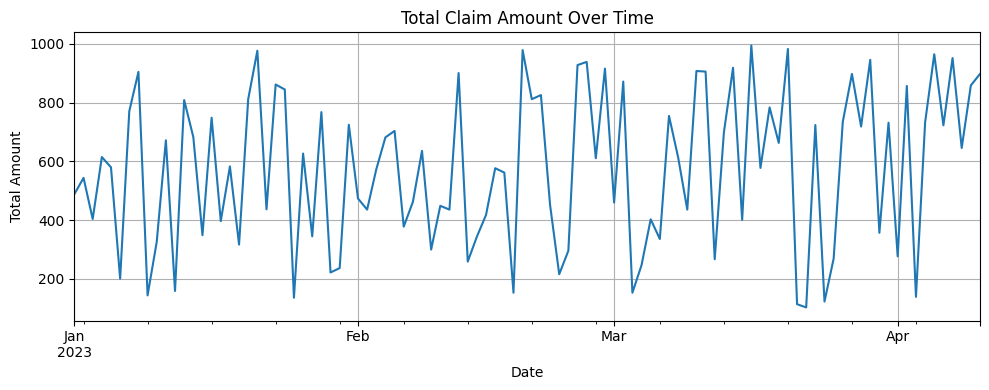

In [31]:
# --- Visualizations ---
# 1. Line chart: Amount over time
plt.figure(figsize=(10, 4))
bronze_df.groupby('DATE')['AMOUNT'].sum().plot()
plt.title('Total Claim Amount Over Time')
plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.grid(True)
plt.tight_layout()
plt.show()

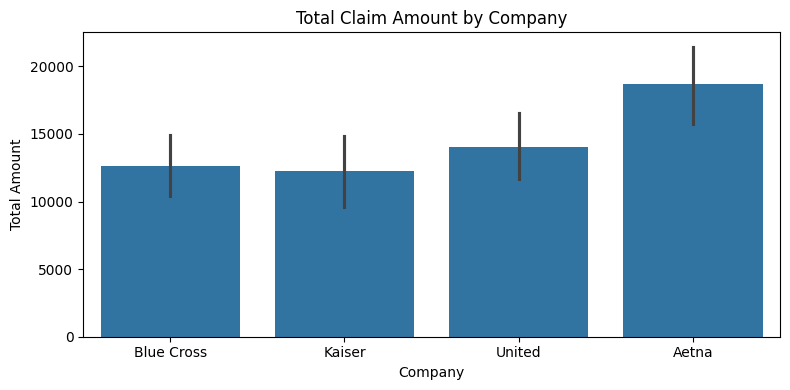

In [32]:
# 2. Bar chart: Company-wise total claims
plt.figure(figsize=(8, 4))
sns.barplot(data=bronze_df, x='COMPANY', y='AMOUNT', estimator=sum)
plt.title('Total Claim Amount by Company')
plt.ylabel('Total Amount')
plt.xlabel('Company')
plt.tight_layout()
plt.show()

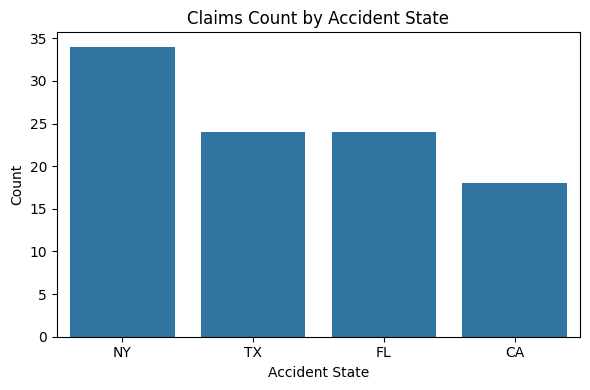

In [33]:
# 3. Count plot: Claims by Accident State
plt.figure(figsize=(6, 4))
sns.countplot(data=bronze_df, x='ACCIDENT_STATE', order=bronze_df['ACCIDENT_STATE'].value_counts().index)
plt.title('Claims Count by Accident State')
plt.xlabel('Accident State')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [36]:
print("Available columns:", bronze_df.columns.tolist())


Available columns: ['DATE', 'AMOUNT', 'COMPANY', 'ACCIDENT_STATE']


In [39]:
# Validate essential columns before applying QC
available_cols = bronze_df.columns.tolist()
essential_cols = ['CLAIM_NUMBER', 'AMOUNT', 'DATE']

# Remove missing ones
valid_essential_cols = [col for col in essential_cols if col in available_cols]

if not valid_essential_cols:
    raise ValueError("No valid essential columns found for QC.")

# Now run QC
qc_passed = bronze_df.dropna(subset=valid_essential_cols).copy()
qc_failed = bronze_df[bronze_df[valid_essential_cols].isnull().any(axis=1)].copy()



In [40]:
# Cast object columns to string for QC Passed
for col in qc_passed.select_dtypes(include='object').columns:
    qc_passed[col] = qc_passed[col].astype(str)

# Cast object columns to string for QC Failed
for col in qc_failed.select_dtypes(include='object').columns:
    qc_failed[col] = qc_failed[col].astype(str)

# Save QC Passed → Staging (Silver)
qc_passed.to_csv(staging_path / "claims_staging.csv", index=False)
qc_passed.to_parquet(staging_path / "claims_staging.parquet", index=False)

# Save QC Failed → Review Table
qc_failed.to_csv(failed_path / "claims_failed.csv", index=False)
qc_failed.to_parquet(failed_path / "claims_failed.parquet", index=False)

print("✅ Bronze → QC → Staging and Failed layers created successfully.")


✅ Bronze → QC → Staging and Failed layers created successfully.


In [41]:
def cast_object_columns_to_str(df):
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].astype(str)
    return df

qc_passed = cast_object_columns_to_str(qc_passed)
qc_failed = cast_object_columns_to_str(qc_failed)
